In [23]:
# Import libraries
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from tqdm.auto import trange
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [7]:
# Import datasets

sep_data = th.load('../datasets/sep_states1.pt')

ent_data = th.load('../datasets/ent_states1.pt')

sep_data_pair = th.stack((sep_data.real, sep_data.imag), dim=1)
ent_data_pair = th.stack((ent_data.real, ent_data.imag), dim=1)

sep_data_pair.shape, ent_data_pair.shape

(torch.Size([30000, 2, 81]), torch.Size([30000, 2, 81]))

In [8]:
# Split the data into training and testing sets

sep_train, sep_test = train_test_split(sep_data_pair, test_size=0.3)
ent_train, ent_test = train_test_split(ent_data_pair, test_size=0.3)

sep_train.shape, sep_test.shape, ent_train.shape, ent_test.shape

(torch.Size([21000, 2, 81]),
 torch.Size([9000, 2, 81]),
 torch.Size([21000, 2, 81]),
 torch.Size([9000, 2, 81]))

In [9]:
BATCH_SIZE = 64
ent_train_loader = DataLoader(ent_train, batch_size=BATCH_SIZE, shuffle=True)
ent_test_loader = DataLoader(ent_test, batch_size=BATCH_SIZE, shuffle=True)
sep_train_loader = DataLoader(sep_train, batch_size=BATCH_SIZE, shuffle=True)
sep_test_loader = DataLoader(sep_test, batch_size=BATCH_SIZE, shuffle=True)

In [13]:
## Import train and test dataset, scale them and convert them to data loaders

from torchvision import datasets, transforms

BATCH_SIZE = 64


MNIST_dataset = datasets.MNIST(
    root="../datasets/",
    train=True,
    transform= transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(0, 1)]),
    download=True
)


100%|██████████| 9912422/9912422 [00:11<00:00, 828890.47it/s] 


Extracting ../datasets/MNIST/raw/train-images-idx3-ubyte.gz to ../datasets/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 939735.72it/s]


Extracting ../datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ../datasets/MNIST/raw



100%|██████████| 1648877/1648877 [00:02<00:00, 667266.28it/s] 


Extracting ../datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ../datasets/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 1117791.98it/s]

Extracting ../datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../datasets/MNIST/raw



In [14]:
data, labels = MNIST_dataset.data, MNIST_dataset.targets

mask = labels == 6

MNIST_6 = data[mask].float()

In [15]:
train_loader = DataLoader(dataset = MNIST_6,
                          batch_size = BATCH_SIZE,
                          shuffle = True)

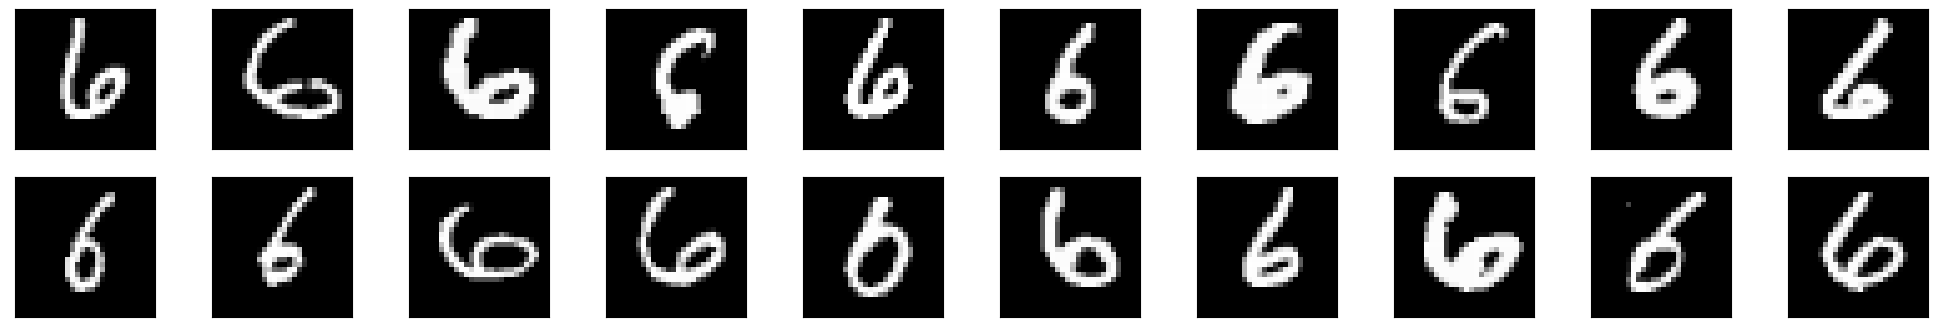

In [8]:
images = next(iter(train_loader)).numpy()

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor

In [16]:
# Define the loss function

def custom_loss(x, x_hat, mean, logvar):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = -0.5 * th.sum(1 + logvar - mean * mean - logvar.exp())
    
    return reproduction_loss + KLD

In [59]:
class VAE_fc(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(VAE_fc, self).__init__()
        self.enc1 = nn.Linear(input_size, hidden_size[0])
        self.enc2 = nn.Linear(hidden_size[0], hidden_size[1])
        self.enc_mu = nn.Linear(hidden_size[1], hidden_size[2])
        self.enc_logvar = nn.Linear(hidden_size[1], hidden_size[2])
        
        self.dec1 = nn.Linear(hidden_size[2], hidden_size[1])
        self.dec2 = nn.Linear(hidden_size[1], hidden_size[0])
        self.dec3 = nn.Linear(hidden_size[0], input_size)
    
    def encoder(self, x):
        
        # print("flatten", x.shape)
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        
        mu = F.relu(self.enc_mu(x))
        logvar = F.relu(self.enc_logvar(x))
        
        return mu, logvar
    
    def reparametrize(self, mu, logvar):
        std = th.exp(0.5 * logvar)
        eps = th.randn_like(std)
        return mu + eps * std 
        
    
    def decoder(self, z):
        z = F.relu(self.dec1(z))
        z = F.relu(self.dec2(z))
        z = th.sigmoid(self.dec3(z))
        return z
    
    
    def forward(self, x):
        # print("input", x.shape)
        x = x.flatten(start_dim=1)
        # print("flatten", x.shape)
        mu, logvar = self.encoder(x)
        z = self.reparametrize(mu, logvar)
        decoded = self.decoder(z)
        return decoded, z, mu, logvar
    
# model = VAE_fc(input_size=81 * 2, hidden_size=[81, 40])

# for _, data in enumerate(ent_train_loader):
#     print(model(data))
#     break

In [89]:
# Define the training function
def train_model(model, train_loader, epochs, optimizer, criterion, device):
    trained_model = model.to(device)
    trained_model.train()
    train_loss = []
    for epoch in range(epochs):
        batch_loss = 0.0
        for data in train_loader:
            optimizer.zero_grad()
            decoded, z, mu, logvar = trained_model(data)
            loss = criterion(data.flatten(start_dim=1), decoded, mu, logvar)
            loss.backward()
            optimizer.step()
            batch_loss += loss.item()
        train_loss.append(batch_loss)
        
        print(f'Epoch: {epoch + 1}, Loss: {batch_loss:.4f}')
    return trained_model, np.array(train_loss)

def get_test_loss(trained_model, test_loader, criterion):
    trained_model.eval()
    decoded_data = []
    test_loss = 0.0
    for _, data in enumerate(test_loader):
        decoded, z, mu, logvar = trained_model(data.flatten(start_dim=1))
        decoded_data.append(decoded.detach().numpy())
        test_loss += criterion(data.flatten(start_dim=1), decoded, mu, logvar).item()
    return test_loss, np.array(decoded_data)

In [61]:
def VAE_loss(input, output, mu, logvar):
    reconstruction_loss = F.mse_loss(output, input, reduction='sum')
    KL_loss = -0.5 * th.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return reconstruction_loss + 0.5 * KL_loss

In [82]:
model = VAE_fc(input_size=81 * 2, hidden_size=[81, 40, 20])
optimizer = th.optim.Adam(model.parameters(), lr=0.001)

trained_model_ent, train_loss_ent = train_model(model, ent_train_loader, 10, optimizer, VAE_loss, 'cpu')

Epoch: 1, Loss: 67116.6707
Epoch: 2, Loss: 163.7779
Epoch: 3, Loss: 142.7865
Epoch: 4, Loss: 134.3121
Epoch: 5, Loss: 131.5442
Epoch: 6, Loss: 127.9978
Epoch: 7, Loss: 126.0550
Epoch: 8, Loss: 124.9797
Epoch: 9, Loss: 124.2636
Epoch: 10, Loss: 121.5827


In [83]:
model = VAE_fc(input_size=81 * 2, hidden_size=[81, 40, 20])
optimizer = th.optim.Adam(model.parameters(), lr=0.001)

trained_model_sep, train_loss_sep = train_model(model, sep_train_loader, 10, optimizer, VAE_loss, 'cpu')

Epoch: 1, Loss: 68782.1323
Epoch: 2, Loss: 154.5444
Epoch: 3, Loss: 59.3687
Epoch: 4, Loss: 47.1066
Epoch: 5, Loss: 40.4807
Epoch: 6, Loss: 38.3686
Epoch: 7, Loss: 37.2783
Epoch: 8, Loss: 35.9002
Epoch: 9, Loss: 34.7022
Epoch: 10, Loss: 34.3626


In [90]:
test_loss_ent = []
test_loss, decoded_ent = get_test_loss(trained_model_ent, ent_test_loader, VAE_loss)
test_loss_ent.append(test_loss)
test_loss, decoded_ent = get_test_loss(trained_model_ent, sep_test_loader, VAE_loss)
test_loss_ent.append(test_loss)

test_loss_sep = []
test_loss, decoded_sep = get_test_loss(trained_model_sep, ent_test_loader, VAE_loss)
test_loss_sep.append(test_loss)
test_loss, decoded_sep = get_test_loss(trained_model_sep, sep_test_loader, VAE_loss)
test_loss_sep.append(test_loss)

test_loss_ent, test_loss_sep

/var/folders/tg/s7bvn5_n5ngb3nrzxqsyqbyw0000gn/T/ipykernel_46266/4184396661.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return test_loss, np.array(decoded_data)


([51.66027361154556, 27.362407095730305],
 [67.31944313645363, 14.414465375244617])

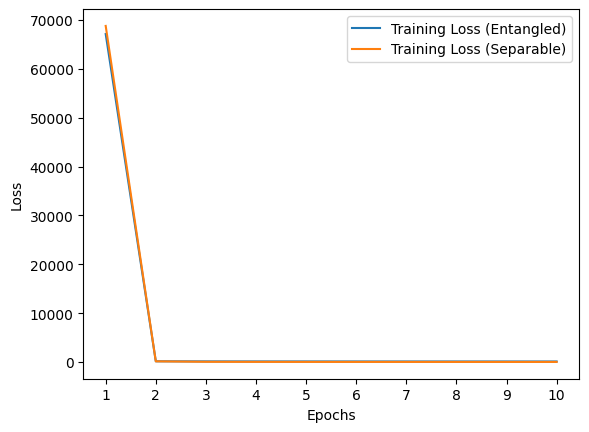

In [85]:
x_values = np.arange(1, len(train_loss_ent) + 1)
plt.plot(x_values, train_loss_ent, label='Training Loss (Entangled)')
plt.plot(x_values, train_loss_sep, label='Training Loss (Separable)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(x_values)
plt.legend()